In [1]:
from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ
from advectionGP.test import TestKernels
from advectionGP.wind import WindFixU #Wind model

import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data

In [2]:
# generate sensor locations with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,15,5) # lower time
xloc=np.linspace(5,15,2) # x locations
yloc=np.linspace(5,15,2) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
X[:,1] = X[:,0]+1


k_0 = 0.01
noiseSD = 0.05

N_feat=1000 # number of features used to approximate GP
boundary = ([0,0,0],[20,20,20]) # corners of the grid
k = EQ(4.0, 2.0) # generate EQ kernel
sensors = FixedSensorModel(X,1) # establish sensor model
res = [80,40,40]

u=[]
u.append(np.ones(res)*0.04) #x direction wind
u.append(np.ones(res)*0.04) # y direction wind
windmodel=WindFixU(u) # establish fixed wind model

m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model



dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute test source
source=m.computeSourceFromPhi(z) # Compute test source
conc=m.computeConcentration(source) # Compute test concentration
y= m.computeObservations(addNoise='TRUE') # Compute observations with noise

The data generated is just the observations (y) at the sensors/observation times defined in X.

This is our synthetic source...

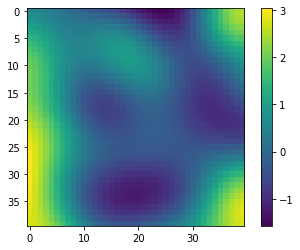

In [3]:
plt.imshow(source[10])
plt.colorbar()

And the synthetic data we will give our adjoint method, is:

In [4]:
y

array([  1.59547261,   1.14121175,   3.47554733,  -4.38638885,
        10.22801102, -15.10371303,  20.6514384 , -20.68896934,
        29.5956785 , -23.03780128,   2.31661943,  -1.29487665,
         0.45309498,  -0.57868601,  -5.44539391,   1.18785669,
        -7.51067467,   1.98073142,  -5.63533046,   2.93282897])

20 observations


(0.0, 20.0)

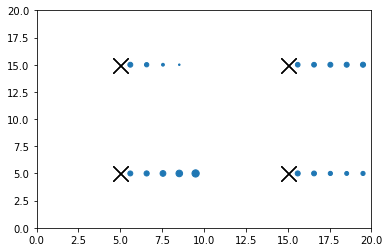

In [5]:
print("%d observations" % len(X))
plt.plot(X[:,2],X[:,3],'xk',markersize=15)
plt.scatter(X[:,2]+X[:,0]*0.3,X[:,3],y-np.min(y))
plt.xlim(m.boundary[0][1],m.boundary[1][1])
plt.ylim(m.boundary[0][2],m.boundary[1][2])


# Try to predict the source from the observations...

In [6]:
k = EQ(4.0, 2.0) # generate EQ kernel
sensors = FixedSensorModel(X,1)
N_feat = 100
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model
X1 = m.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = m.computeZDistribution(y) # Infers z vector mean and covariance
source2 = m.computeSourceFromPhi(meanZ) # Generates estimated source using inferred mean

Calculating Adjoints...
19/20 
Calculating Phis...
99/100 


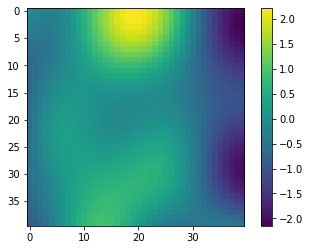

In [7]:
plt.imshow(source2[10])
plt.colorbar()

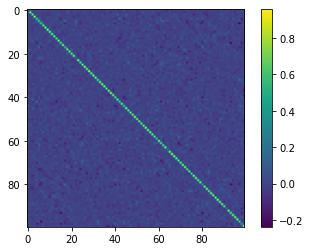

In [8]:
plt.imshow(covZ)
plt.colorbar()

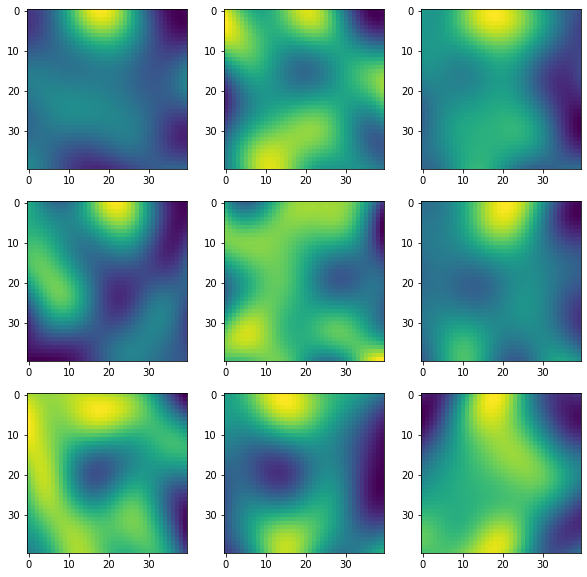

In [9]:
plt.figure(figsize=[10,10])
for sample_i in range(9):
    plt.subplot(3,3,sample_i+1)
    z = np.random.multivariate_normal(meanZ,covZ)
    source = m.computeSourceFromPhi(z) # Generates estimated source using inferred mean
    plt.imshow(source[10])

In [10]:
Nsamps = 500
results = np.zeros(np.r_[res,Nsamps])
for sample_i in range(Nsamps):
    z = np.random.multivariate_normal(meanZ,covZ)
    results[:,:,:,sample_i] = m.computeSourceFromPhi(z) 

KeyboardInterrupt: 

In [ ]:
plt.imshow(np.std(results,3)[12,:,:])
plt.colorbar()
plt.plot(X[:,2]*2,X[:,3]*2,'xk',markersize=15)

In [ ]:
dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize()

$z \sim N(\mu,\Sigma)$ (multivariate normal)

$S \sim N(\Phi(t,x,y)^T\mu,\Phi(t,x,y)^T\Sigma\Phi(t,x,y))$ (normal)

$\Phi(t,x,y)$ is an N_feat x 1 vector $\Phi(t,x,y)=(\phi_j(t,x,y),j\in\{1,...,N_{feat}\})$

$\Phi(t,x,y)^T\Sigma\Phi(t,x,y)) = \Sigma_i\Sigma_j\phi_i(t,x,y)\Sigma_{ij}\phi_j(t,x,y)$

In [ ]:
meanSource = m.computeSourceFromPhi(meanZ)
varSource = np.zeros((Nt,Nx,Ny))
for i,phii in enumerate(m.kernel.getPhi(m.coords)):
    for j,phij in enumerate(m.kernel.getPhi(m.coords)):
        varSource += covZ[i,j]*phii*phij

In [ ]:
plt.imshow(np.sqrt(varSource[12]))
plt.colorbar()
plt.plot(X[:,2]*2,X[:,3]*2,'xk',markersize=15)

In [ ]:
np.sum(np.abs(np.sqrt(varSource)-np.std(results,3)))/(Nx*Ny*Nt)

In [ ]:
phii[0,1,0]*phij[0,,0]

In [ ]:
meanS, varS = m.computeSourceDistribution(meanZ,covZ)

In [ ]:
meanS